In [2]:
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from collections import defaultdict

In [3]:
source_dir = 'data/sunflower_disease_dataset_orig'  # <-- зміни на свій шлях
base_dir = 'data/sunflower_disease_dataset_split'

In [47]:
train_split = 0.7
val_split = 0.15
test_split = 0.15
class_counts = defaultdict(lambda: {'train': 0, 'val': 0, 'test': 0})


In [48]:
for split in ['train', 'val', 'test']:
    for class_name in os.listdir(source_dir):
        os.makedirs(os.path.join(base_dir, split, class_name), exist_ok=True)

In [49]:
for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    images = os.listdir(class_path)
    random.shuffle(images)
    print(class_name)

    train_end = int(len(images) * train_split)
    val_end = train_end + int(len(images) * val_split)

    train_images = images[:train_end]
    val_images = images[train_end:val_end]
    test_images = images[val_end:]

    for img in train_images:
        shutil.copyfile(os.path.join(class_path, img), os.path.join(base_dir, 'train', class_name, img))
    for img in val_images:
        shutil.copyfile(os.path.join(class_path, img), os.path.join(base_dir, 'val', class_name, img))
    for img in test_images:
        shutil.copyfile(os.path.join(class_path, img), os.path.join(base_dir, 'test', class_name, img))

print("✅ Дані успішно розділені на train/val/test!")

Downy mildew
Fresh Leaf
Gray mold
Leaf scars
✅ Дані успішно розділені на train/val/test!


In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [5]:
train_dataset = datasets.ImageFolder(os.path.join(base_dir, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(base_dir, 'val'), transform=transform)
test_dataset = datasets.ImageFolder(os.path.join(base_dir, 'test'), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [6]:
class_names = train_dataset.classes
print(f"Класи: {class_names}")

Класи: ['Downy mildew', 'Fresh Leaf', 'Gray mold', 'Leaf scars']


In [ ]:
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, len(class_names))

print(model)


In [24]:
from efficientnet_pytorch import EfficientNet

efficientnet = EfficientNet.from_pretrained('efficientnet-b0')

for param in efficientnet.parameters():
    param.requires_grad = False

efficientnet._fc = nn.Linear(efficientnet._fc.in_features, len(class_names))

for param in efficientnet._fc.parameters():
    param.requires_grad = True

Loaded pretrained weights for efficientnet-b0


In [7]:
mobilenet = models.mobilenet_v2(pretrained=True)

for param in mobilenet.parameters():
    param.requires_grad = False

mobilenet.classifier[1] = nn.Linear(mobilenet.classifier[1].in_features, len(class_names))

for param in mobilenet.classifier[1].parameters():
    param.requires_grad = True

print(mobilenet)

C:\Users\ACER\.virtualenvs\pythonProject17-DdFQsw_w\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ACER\.virtualenvs\pythonProject17-DdFQsw_w\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [26]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
# optimizer = optim.Adam(mobilenet.classifier[1].parameters(), lr=1e-4)
optimizer = optim.Adam(efficientnet._fc.parameters(), lr=1e-4)

In [9]:
from sklearn.metrics import precision_score, recall_score, f1_score
import time

precision_list = []
recall_list = []
f1_list = []
inference_times_ms = []

num_epochs = 10

train_losses = []
train_accuracies = []
val_accuracies = []

start_time = time.time()

for epoch in range(num_epochs):
    mobilenet.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:

        optimizer.zero_grad()
        outputs = mobilenet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    avg_train_loss = running_loss / len(train_loader)

    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # --- ОЦІНКА НА ВАЛІДАЦІЇ ---
    mobilenet.eval()
    val_correct, val_total = 0, 0
    val_preds = []
    val_true = []
    inference_time_epoch = 0

    with torch.no_grad():
        for images, labels in val_loader:

            start_infer = time.time()
            outputs = mobilenet(images)
            _, predicted = torch.max(outputs, 1)
            end_infer = time.time()

            inference_time_epoch += (end_infer - start_infer)

            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            val_preds.extend(predicted.cpu().numpy())
            val_true.extend(labels.cpu().numpy())

    val_acc = 100 * val_correct / val_total
    val_accuracies.append(val_acc)

    # --- ДОДАТКОВІ МЕТРИКИ ---
    precision = precision_score(val_true, val_preds, average='macro')
    recall = recall_score(val_true, val_preds, average='macro')
    f1 = f1_score(val_true, val_preds, average='macro')
    avg_infer_ms = inference_time_epoch * 1000 / len(val_loader.dataset)

    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    inference_times_ms.append(avg_infer_ms)

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Train Acc: {train_acc:.2f}%, "
          f"Val Acc: {val_acc:.2f}%, "
          f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}, "
          f"Infer time: {avg_infer_ms:.2f} ms")

end_time = time.time()
print(f"\n⏳ Тренування завершено за {end_time - start_time:.2f} секунд!")


Epoch [1/10] - Train Loss: 0.5329, Train Acc: 81.71%, Val Acc: 93.26%, Precision: 0.93, Recall: 0.94, F1: 0.93, Infer time: 19.52 ms
Epoch [2/10] - Train Loss: 0.1338, Train Acc: 96.52%, Val Acc: 95.04%, Precision: 0.95, Recall: 0.95, F1: 0.95, Infer time: 20.50 ms
Epoch [3/10] - Train Loss: 0.0381, Train Acc: 99.09%, Val Acc: 95.39%, Precision: 0.96, Recall: 0.96, F1: 0.96, Infer time: 19.40 ms
Epoch [4/10] - Train Loss: 0.0222, Train Acc: 99.55%, Val Acc: 95.39%, Precision: 0.96, Recall: 0.96, F1: 0.96, Infer time: 19.27 ms
Epoch [5/10] - Train Loss: 0.0199, Train Acc: 99.55%, Val Acc: 95.39%, Precision: 0.96, Recall: 0.96, F1: 0.96, Infer time: 19.40 ms
Epoch [6/10] - Train Loss: 0.0135, Train Acc: 99.92%, Val Acc: 96.45%, Precision: 0.97, Recall: 0.97, F1: 0.97, Infer time: 19.44 ms
Epoch [7/10] - Train Loss: 0.0055, Train Acc: 100.00%, Val Acc: 96.10%, Precision: 0.96, Recall: 0.96, F1: 0.96, Infer time: 19.13 ms
Epoch [8/10] - Train Loss: 0.0057, Train Acc: 99.92%, Val Acc: 96.45

C:\Users\ACER\AppData\Local\Temp\ipykernel_9828\68218392.py:36: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ACER\.virtualenvs\pythonProject17-DdFQsw_w\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


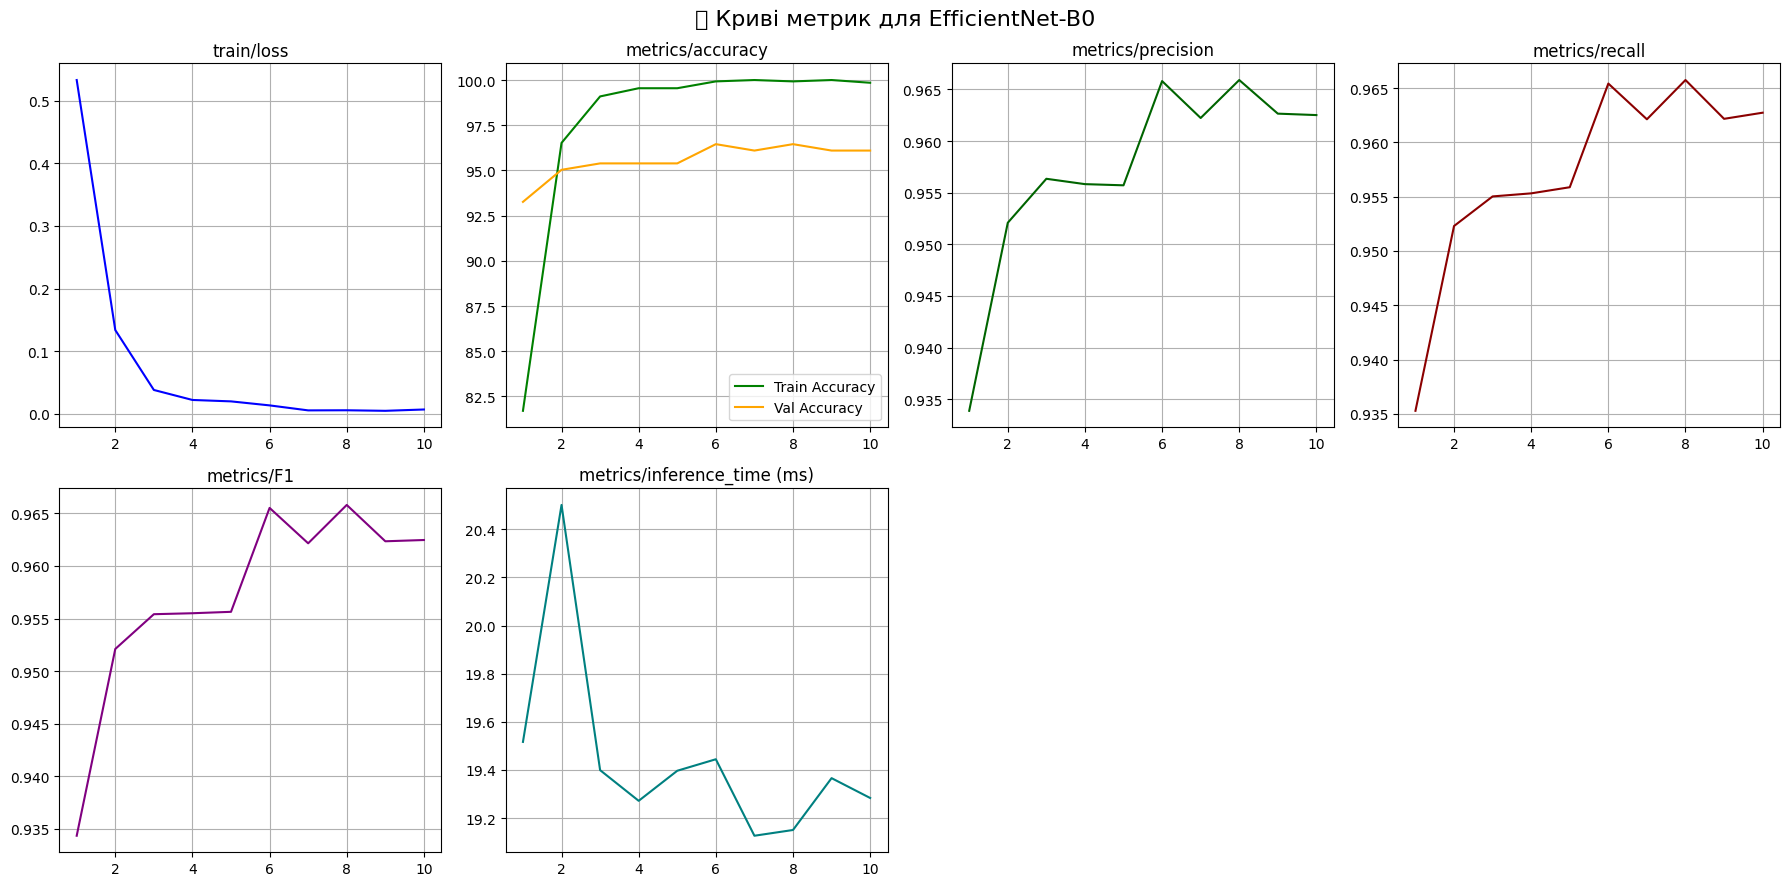

In [10]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 4, figsize=(18, 9))
axes = axes.flatten()

axes[0].plot(range(1, len(train_losses)+1), train_losses, label='Train Loss', color='blue')
axes[0].set_title("train/loss")
axes[0].grid(True)

axes[1].plot(range(1, len(train_accuracies)+1), train_accuracies, label='Train Accuracy', color='green')
axes[1].plot(range(1, len(val_accuracies)+1), val_accuracies, label='Val Accuracy', color='orange')
axes[1].set_title("metrics/accuracy")
axes[1].legend()
axes[1].grid(True)

axes[2].plot(range(1, len(precision_list)+1), precision_list, label='Precision', color='darkgreen')
axes[2].set_title("metrics/precision")
axes[2].grid(True)

axes[3].plot(range(1, len(recall_list)+1), recall_list, label='Recall', color='darkred')
axes[3].set_title("metrics/recall")
axes[3].grid(True)

axes[4].plot(range(1, len(f1_list)+1), f1_list, label='F1 Score', color='purple')
axes[4].set_title("metrics/F1")
axes[4].grid(True)

axes[5].plot(range(1, len(inference_times_ms)+1), inference_times_ms, label='Inference time', color='teal')
axes[5].set_title("metrics/inference_time (ms)")
axes[5].grid(True)

axes[6].axis("off")
axes[7].axis("off")

plt.suptitle("📊 Криві метрик для EfficientNet-B0", fontsize=16)
plt.tight_layout()
plt.show()

In [11]:
torch.save(mobilenet.state_dict(), "models/mobilenet_disease.pth")

In [12]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Точність моделі на тестових даних: {accuracy:.2f}%")

evaluate_model(mobilenet, test_loader)


Точність моделі на тестових даних: 98.95%


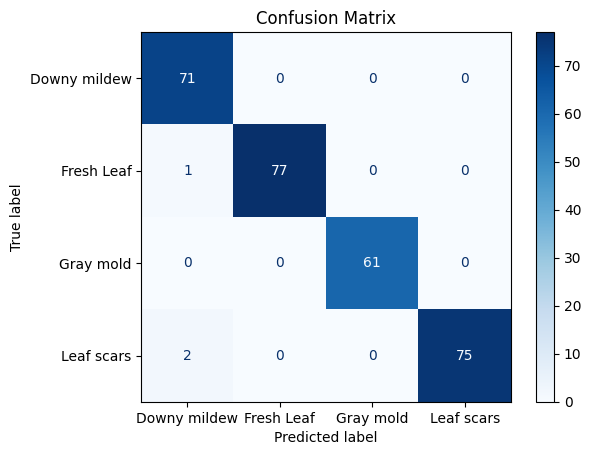

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np


y_true = []
y_pred = []
y_score =[]

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = mobilenet(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())
        y_score.extend(torch.softmax(outputs, dim=1).cpu().numpy())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [19]:
y_true = label_binarize(y_true, classes=list(range(4)))
y_score = np.array(y_score)

C:\Users\ACER\AppData\Local\Temp\ipykernel_9828\4221959652.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", 4)


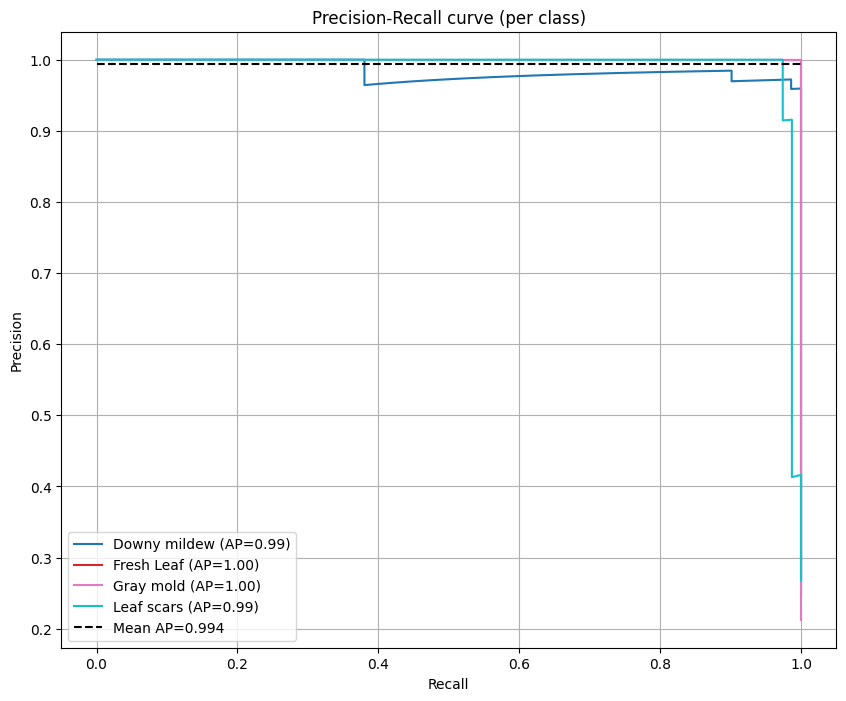

In [20]:
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap("tab10", 4)

average_precisions = []

for i in range(4):
    precision, recall, _ = precision_recall_curve(y_true[:, i], y_score[:, i])
    ap = average_precision_score(y_true[:, i], y_score[:, i])
    average_precisions.append(ap)
    plt.plot(recall, precision, label=f"{class_names[i]} (AP={ap:.2f})", color=colors(i))

mean_ap = np.mean(average_precisions)
plt.plot([0, 1], [mean_ap, mean_ap], "k--", label=f"Mean AP={mean_ap:.3f}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curve (per class)")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()


In [18]:
from sklearn.metrics import classification_report
report = classification_report(y_true, y_pred, target_names=class_names)
print("\n[MobileNet] Classification Report:")
print(report)

accuracy = np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true)
print(f"Точність MobileNet на тестовому наборі: {accuracy:.4f}")


[MobileNet] Classification Report:
              precision    recall  f1-score   support

Downy mildew       0.96      1.00      0.98        71
  Fresh Leaf       1.00      0.99      0.99        78
   Gray mold       1.00      1.00      1.00        61
  Leaf scars       1.00      0.97      0.99        77

    accuracy                           0.99       287
   macro avg       0.99      0.99      0.99       287
weighted avg       0.99      0.99      0.99       287

Точність MobileNet на тестовому наборі: 0.9895


In [23]:
# Якщо нормалізували як ImageNet (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def denormalize(img_tensor):
    img = img_tensor.numpy().transpose((1, 2, 0))  # CHW -> HWC
    img = (img * imagenet_std) + imagenet_mean
    img = np.clip(img, 0, 1)
    return img


In [24]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def show_class_examples(model, dataloader, class_names):
    model.eval()
    shown_classes = set()
    images_to_show = []
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for img, true_label, pred_label in zip(inputs, labels, preds.cpu()):
                if true_label.item() not in shown_classes:
                    shown_classes.add(true_label.item())
                    images_to_show.append(img.cpu())
                    true_labels.append(true_label.item())
                    predicted_labels.append(pred_label.item())
                if len(shown_classes) == len(class_names):
                    break
            if len(shown_classes) == len(class_names):
                break

    # Вивід зображень
    plt.figure(figsize=(16, 8))
    for idx, img in enumerate(images_to_show):
        plt.subplot(2, len(images_to_show)//2 + 1, idx + 1)
        img = denormalize(img)
        plt.imshow(img)
        plt.title(f"Справжній: {class_names[true_labels[idx]]}\nПередбачено: {class_names[predicted_labels[idx]]}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


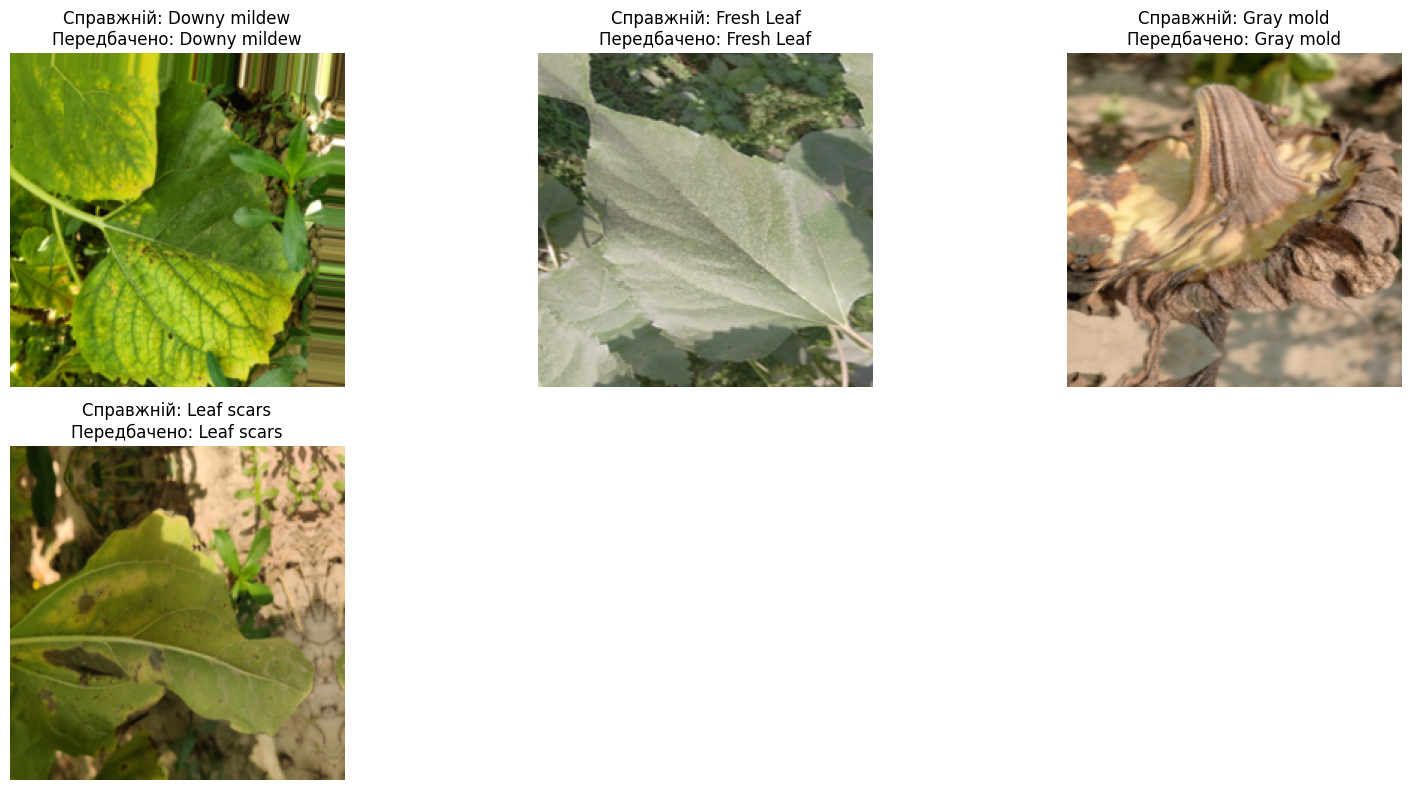

In [25]:
show_class_examples(mobilenet, test_loader, class_names)
